In [760]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
import seaborn as sns
sns.set()
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
from tensorflow.keras import utils
from tensorflow.python.keras import backend
import os
import tempfile

In [167]:
# Load the plant 1 training data set
train1 = pd.read_csv('plant1_train.csv')
train1 = train1.fillna(0)
train1 = train1.iloc[:,2:]
train1['mea_ddhr'] = pd.to_datetime(train1['mea_ddhr'])
train1['plant'] = 1
train1 = pd.wide_to_long(train1, ["tem_in", "hum_in","tem_coil","cond"], i=["mea_ddhr"], j="loc", sep='_loc')
train1.tail()

,,tem_out_loc1,hum_out_loc1,plant,tem_in,hum_in,tem_coi,cond
mea_ddhr,loc,,,,,,,
2019-03-31 23:10:00,3,6.40,43.86,1,9.85,37.88,9.79,0.0
2019-03-31 23:20:00,3,6.34,44.02,1,9.88,38.40,9.72,0.0
2019-03-31 23:30:00,3,6.40,43.04,1,9.85,38.22,9.91,0.0
2019-03-31 23:40:00,3,6.31,45.33,1,9.82,38.95,9.83,0.0
2019-03-31 23:50:00,3,6.34,45.94,1,9.82,39.35,9.83,0.0


In [179]:
# Load the plant 2 training data set
train2 = pd.read_csv('plant2_train.csv')
train2 = train2.fillna(0)
train2 = train2.iloc[:,2:]
train2['mea_ddhr'] = pd.to_datetime(train2['mea_ddhr'])
train2['plant'] = 2
train2 = pd.wide_to_long(train2, ["tem_in", "hum_in","tem_coil","cond"], i=["mea_ddhr"], j="loc", sep='_loc')
train2.tail()

,,tem_out_loc1,hum_out_loc1,plant,tem_in,hum_in,tem_coi,cond
mea_ddhr,loc,,,,,,,
2019-03-31 23:10:00,3,4.72,52.11,2,8.26,38.34,9.57,0.0
2019-03-31 23:20:00,3,4.66,51.01,2,8.29,38.92,9.60,0.0
2019-03-31 23:30:00,3,4.57,51.47,2,8.32,39.13,9.49,0.0
2019-03-31 23:40:00,3,4.47,53.14,2,8.26,39.62,9.57,0.0
2019-03-31 23:50:00,3,0.00,0.00,2,0.00,0.00,0.00,0.0


In [437]:
frames = [train1, train2]
total_train = pd.concat(frames)
total_train = total_train.reset_index()
total_train = total_train.iloc[:,[0,4,1,5,6,7,2,3,8]]
total_train.head()

,mea_ddhr,plant,loc,tem_in,hum_in,tem_coi,tem_out_loc1,hum_out_loc1,cond
0,2016-04-01 00:00:00,1,1,16.0,24.0,11.0,9.0,42.0,0.0
1,2016-04-01 03:00:00,1,1,14.0,28.0,10.0,7.0,59.0,0.0
2,2016-04-01 06:00:00,1,1,13.0,33.0,10.0,6.0,56.0,0.0
3,2016-04-01 09:00:00,1,1,13.0,33.0,10.0,18.0,30.0,0.0
4,2016-04-01 12:00:00,1,1,16.0,28.0,10.0,18.0,20.0,0.0


In [438]:
total_train.shape

(349989, 9)

In [450]:
total_train['x24h_tma'] = total_train['mea_ddhr'] + timedelta(days=1)
total_train['x24h_cond_loc'] = 0
total_train['x48h_tma'] = total_train['mea_ddhr'] + timedelta(days=2)
total_train['x48h_cond_loc'] = 0

In [443]:
total_train = total_train.reset_index(drop=True)

In [440]:
condensation = total_train[total_train['cond'] == 1].sort_values(by=['mea_ddhr'])

In [451]:
condensation.head()

,mea_ddhr,plant,loc,tem_in,hum_in,tem_coi,tem_out_loc1,hum_out_loc1,cond,x24h_tma,x24h_cond_loc,x48h_tma,x48h_cond_loc
117541,2016-04-06 09:00:00,1,3,13.0,84.0,11.0,11.0,45.0,1.0,2016-04-07 09:00:00,0,2016-04-08 09:00:00,0
117557,2016-04-08 09:00:00,1,3,12.0,82.0,9.0,9.0,75.0,1.0,2016-04-09 09:00:00,0,2016-04-10 09:00:00,0
58808,2016-04-08 09:00:00,1,2,13.0,80.0,10.0,9.0,75.0,1.0,2016-04-09 09:00:00,0,2016-04-10 09:00:00,0
117558,2016-04-08 12:00:00,1,3,13.0,80.0,10.0,12.0,63.0,1.0,2016-04-09 12:00:00,0,2016-04-10 12:00:00,0
117563,2016-04-09 03:00:00,1,3,13.0,77.0,10.0,9.0,80.0,1.0,2016-04-10 03:00:00,0,2016-04-11 03:00:00,0


In [431]:
condensation = condensation.reset_index(drop=True)

In [448]:
total_train[(total_train['x24h_tma'] == condensation['mea_ddhr'].values[0]) & (total_train['plant'] == condensation['plant'].values[0]) & (total_train['loc'] == condensation['loc'].values[0])]['x24h_cond_loc']

117533    0
Name: x24h_cond_loc, dtype: int64

In [452]:
for i in range(len(condensation['mea_ddhr'].values)):
    total_train.loc[(total_train['x24h_tma'] == condensation['mea_ddhr'].values[i]) & (total_train['plant'] == condensation['plant'].values[i]) & (total_train['loc'] == condensation['loc'].values[i]), 'x24h_cond_loc'] = 1
    total_train.loc[(total_train['x48h_tma'] == condensation['mea_ddhr'].values[i]) & (total_train['plant'] == condensation['plant'].values[i]) & (total_train['loc'] == condensation['loc'].values[i]), 'x48h_cond_loc'] = 1
    

In [453]:
total_train.describe()

,plant,loc,tem_in,hum_in,tem_coi,tem_out_loc1,hum_out_loc1,cond,x24h_cond_loc,x48h_cond_loc
count,349989.000000,349989.000000,349989.000000,349989.000000,349989.000000,349989.000000,349989.000000,349989.000000,349989.000000,349989.000000
mean,1.496421,2.000000,16.300226,52.241778,15.860972,13.583537,61.745743,0.005654,0.005654,0.005654
std,0.499988,0.816498,10.021232,14.334147,10.148261,11.089872,19.050421,0.074983,0.074983,0.074983
min,1.000000,1.000000,-8.930000,0.000000,-7.610000,-14.270000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,7.340000,41.700000,6.590000,3.960000,47.190000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,15.530000,52.410000,15.100000,12.870000,61.050000,0.000000,0.000000,0.000000
75%,2.000000,3.000000,25.450000,63.100000,25.320000,23.130000,76.950000,0.000000,0.000000,0.000000
max,2.000000,3.000000,37.080000,93.160000,35.240000,43.420000,99.510000,1.000000,1.000000,1.000000


In [454]:
total_train = total_train.drop('cond', axis = 1)

In [455]:
total_train.head()

,mea_ddhr,plant,loc,tem_in,hum_in,tem_coi,tem_out_loc1,hum_out_loc1,x24h_tma,x24h_cond_loc,x48h_tma,x48h_cond_loc
0,2016-04-01 00:00:00,1,1,16.0,24.0,11.0,9.0,42.0,2016-04-02 00:00:00,0,2016-04-03 00:00:00,0
1,2016-04-01 03:00:00,1,1,14.0,28.0,10.0,7.0,59.0,2016-04-02 03:00:00,0,2016-04-03 03:00:00,0
2,2016-04-01 06:00:00,1,1,13.0,33.0,10.0,6.0,56.0,2016-04-02 06:00:00,0,2016-04-03 06:00:00,0
3,2016-04-01 09:00:00,1,1,13.0,33.0,10.0,18.0,30.0,2016-04-02 09:00:00,0,2016-04-03 09:00:00,0
4,2016-04-01 12:00:00,1,1,16.0,28.0,10.0,18.0,20.0,2016-04-02 12:00:00,0,2016-04-03 12:00:00,0


In [482]:
# Load the plant test data set
test = pd.read_csv('plant_test.csv')
test = test.iloc[:,1:]
test['mea_ddhr'] = pd.to_datetime(test['mea_ddhr'])
test.head()

,mea_ddhr,plant,loc,tem_in,hum_in,tem_coil,tem_out_loc1,hum_out_loc1,x24h_tma,x24h_cond_loc,x48h_tma,x48h_cond_loc
0,2019-04-01 00:00:00,2,3,8.17,40.42,10.10,4.20,54.82,2019-04-02 0:00,NaN,2019-04-03 0:00,NaN
1,2019-04-01 04:30:00,1,2,10.03,48.81,10.79,6.09,59.34,2019-04-02 4:30,NaN,2019-04-03 4:30,NaN
2,2019-04-01 10:30:00,2,3,9.45,40.93,9.07,12.26,32.14,2019-04-02 10:30,NaN,2019-04-03 10:30,NaN
3,2019-04-01 11:00:00,1,1,12.32,34.13,10.86,12.32,28.27,2019-04-02 11:00,NaN,2019-04-03 11:00,NaN
4,2019-04-01 13:30:00,2,1,11.28,22.65,8.76,12.01,19.84,2019-04-02 13:30,NaN,2019-04-03 13:30,NaN


In [492]:
# Load the weather data from the observation point on the outside of factory
weather = pd.read_csv('weather_data.csv')
weather = weather.iloc[:,1:]
weather['일시'] = pd.to_datetime(weather['일시'])
weather.tail()

,일시,기온(°C),누적강수량(mm),풍속(m/s),현지기압(hPa),해면기압(hPa),습도(%)
111282,2020-03-31 23:20:00,7.5,0.0,1.4,1012.7,1015.8,59.0
111283,2020-03-31 23:30:00,8.0,0.0,1.0,1012.7,1015.8,52.5
111284,2020-03-31 23:40:00,8.6,0.0,1.6,1012.7,1015.8,46.0
111285,2020-03-31 23:50:00,8.6,0.0,1.0,1012.7,1015.8,47.2
111286,2020-04-01 00:00:00,8.4,0.0,0.8,1012.7,1015.8,52.0


In [7]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58749 entries, 0 to 58748
Data columns (total 15 columns):
mea_ddhr         58749 non-null object
tem_in_loc1      58749 non-null float64
hum_in_loc1      58749 non-null float64
tem_coil_loc1    58749 non-null float64
tem_in_loc2      58749 non-null float64
hum_in_loc2      58749 non-null float64
tem_coil_loc2    58749 non-null float64
tem_in_loc3      58749 non-null float64
hum_in_loc3      58749 non-null float64
tem_coil_loc3    58749 non-null float64
tem_out_loc1     58749 non-null float64
hum_out_loc1     58749 non-null float64
cond_loc1        58749 non-null float64
cond_loc2        58749 non-null float64
cond_loc3        58749 non-null float64
dtypes: float64(14), object(1)
memory usage: 6.7+ MB


In [475]:
weather.describe()

,기온(°C),누적강수량(mm),풍속(m/s),현지기압(hPa),해면기압(hPa),습도(%)
count,111279.000000,109149.000000,111283.000000,111273.000000,111273.000000,111284.000000
mean,12.476933,1.373145,1.859155,1014.106383,1017.311511,73.044964
std,10.515506,7.172807,1.555926,8.499238,8.584265,20.585989
min,-15.600000,0.000000,0.000000,983.500000,986.300000,8.900000
25%,3.600000,0.000000,0.700000,1007.400000,1010.500000,57.200000
50%,12.400000,0.000000,1.500000,1014.500000,1017.700000,75.600000
75%,21.600000,0.000000,2.800000,1020.600000,1023.900000,92.700000
max,37.100000,139.300000,13.200000,1036.400000,1039.800000,100.000000


In [476]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111287 entries, 0 to 111286
Data columns (total 7 columns):
일시           111287 non-null datetime64[ns]
기온(°C)       111279 non-null float64
누적강수량(mm)    109149 non-null float64
풍속(m/s)      111283 non-null float64
현지기압(hPa)    111273 non-null float64
해면기압(hPa)    111273 non-null float64
습도(%)        111284 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 5.9 MB


In [477]:
weather.shape

(111287, 7)

In [11]:
train1.shape

(58749, 15)

In [494]:
weather = weather.rename(columns={'일시': 'mea_ddhr','기온(°C)':'out_temp','누적강수량(mm)':'cum_rain','풍속(m/s)':'wind_speed','현지기압(hPa)':'land_pressure','해면기압(hPa)':'ocean_pressure','습도(%)':'out_humidity'})

In [723]:
mix_train = total_train.merge(weather, on='mea_ddhr', how='left')

In [721]:
mix_test = test.merge(weather, on='mea_ddhr', how='left')

## EDA

In [724]:
mix_train = mix_train.rename(columns={'tem_coi': 'tem_coil'})
mix_train.head()

,mea_ddhr,plant,loc,tem_in,hum_in,tem_coil,tem_out_loc1,hum_out_loc1,x24h_tma,x24h_cond_loc,x48h_tma,x48h_cond_loc,out_temp,cum_rain,wind_speed,land_pressure,ocean_pressure,out_humidity
0,2016-04-01 00:00:00,1,1,16.0,24.0,11.0,9.0,42.0,2016-04-02 00:00:00,0,2016-04-03 00:00:00,0,8.8,0.0,1.5,1012.1,1015.6,41.0
1,2016-04-01 03:00:00,1,1,14.0,28.0,10.0,7.0,59.0,2016-04-02 03:00:00,0,2016-04-03 03:00:00,0,7.5,0.0,0.4,1011.4,1014.9,40.0
2,2016-04-01 06:00:00,1,1,13.0,33.0,10.0,6.0,56.0,2016-04-02 06:00:00,0,2016-04-03 06:00:00,0,3.7,0.0,0.4,1011.9,1015.5,66.0
3,2016-04-01 09:00:00,1,1,13.0,33.0,10.0,18.0,30.0,2016-04-02 09:00:00,0,2016-04-03 09:00:00,0,12.9,0.0,0.7,1013.2,1016.7,41.0
4,2016-04-01 12:00:00,1,1,16.0,28.0,10.0,18.0,20.0,2016-04-02 12:00:00,0,2016-04-03 12:00:00,0,20.5,0.0,2.4,1012.4,1015.8,24.0


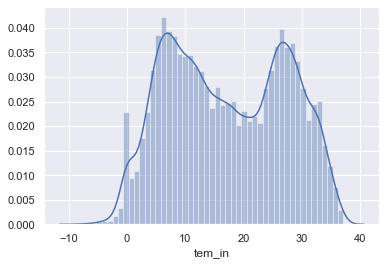

In [377]:
sns.distplot(mix_train[(mix_train["plant"] == 1) & (mix_train["loc"] == 1)]['tem_in'].dropna())

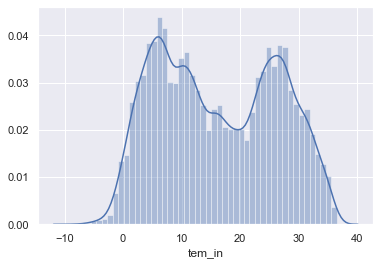

In [378]:
sns.distplot(mix_train[(mix_train["plant"] == 1) & (mix_train["loc"] == 2)]['tem_in'].dropna())

In [425]:
train1_2018 = mix_train[(mix_train['mea_ddhr'] < '2019-01-01 00:00:00') &(mix_train['mea_ddhr'] >= '2018-01-01 00:00:00')]
train1_2018.head()

,mea_ddhr,plant,loc,tem_in,hum_in,tem_coil,tem_out_loc1,hum_out_loc1,x24h_tma,x24h_cond_loc,x48h_tma,x48h_cond_loc,out_temp,cum_rain,wind_speed,land_pressure,ocean_pressure,out_humidity
10850,2018-01-01 00:00:00,1,1,6.83,35.87,6.05,0.93,45.79,2018-01-02 00:00:00,0,2018-01-03 00:00:00,0,-2.1,0.0,1.1,1023.6,1027.3,70.0
10851,2018-01-01 01:00:00,1,1,6.79,33.79,6.05,0.29,49.66,2018-01-02 01:00:00,0,2018-01-03 01:00:00,0,-3.5,0.0,1.0,1023.5,1027.2,79.0
10852,2018-01-01 02:00:00,1,1,6.67,33.46,6.02,0.11,44.57,2018-01-02 02:00:00,0,2018-01-03 02:00:00,0,-4.3,0.0,0.4,1023.5,1027.3,86.0
10853,2018-01-01 03:00:00,1,1,6.46,31.35,5.94,0.05,41.97,2018-01-02 03:00:00,0,2018-01-03 03:00:00,0,-5.1,0.0,0.2,1023.8,1027.6,89.0
10854,2018-01-01 04:00:00,1,1,6.00,33.36,5.86,-2.82,58.97,2018-01-02 04:00:00,0,2018-01-03 04:00:00,0,-5.6,0.0,0.6,1023.8,1027.6,90.0


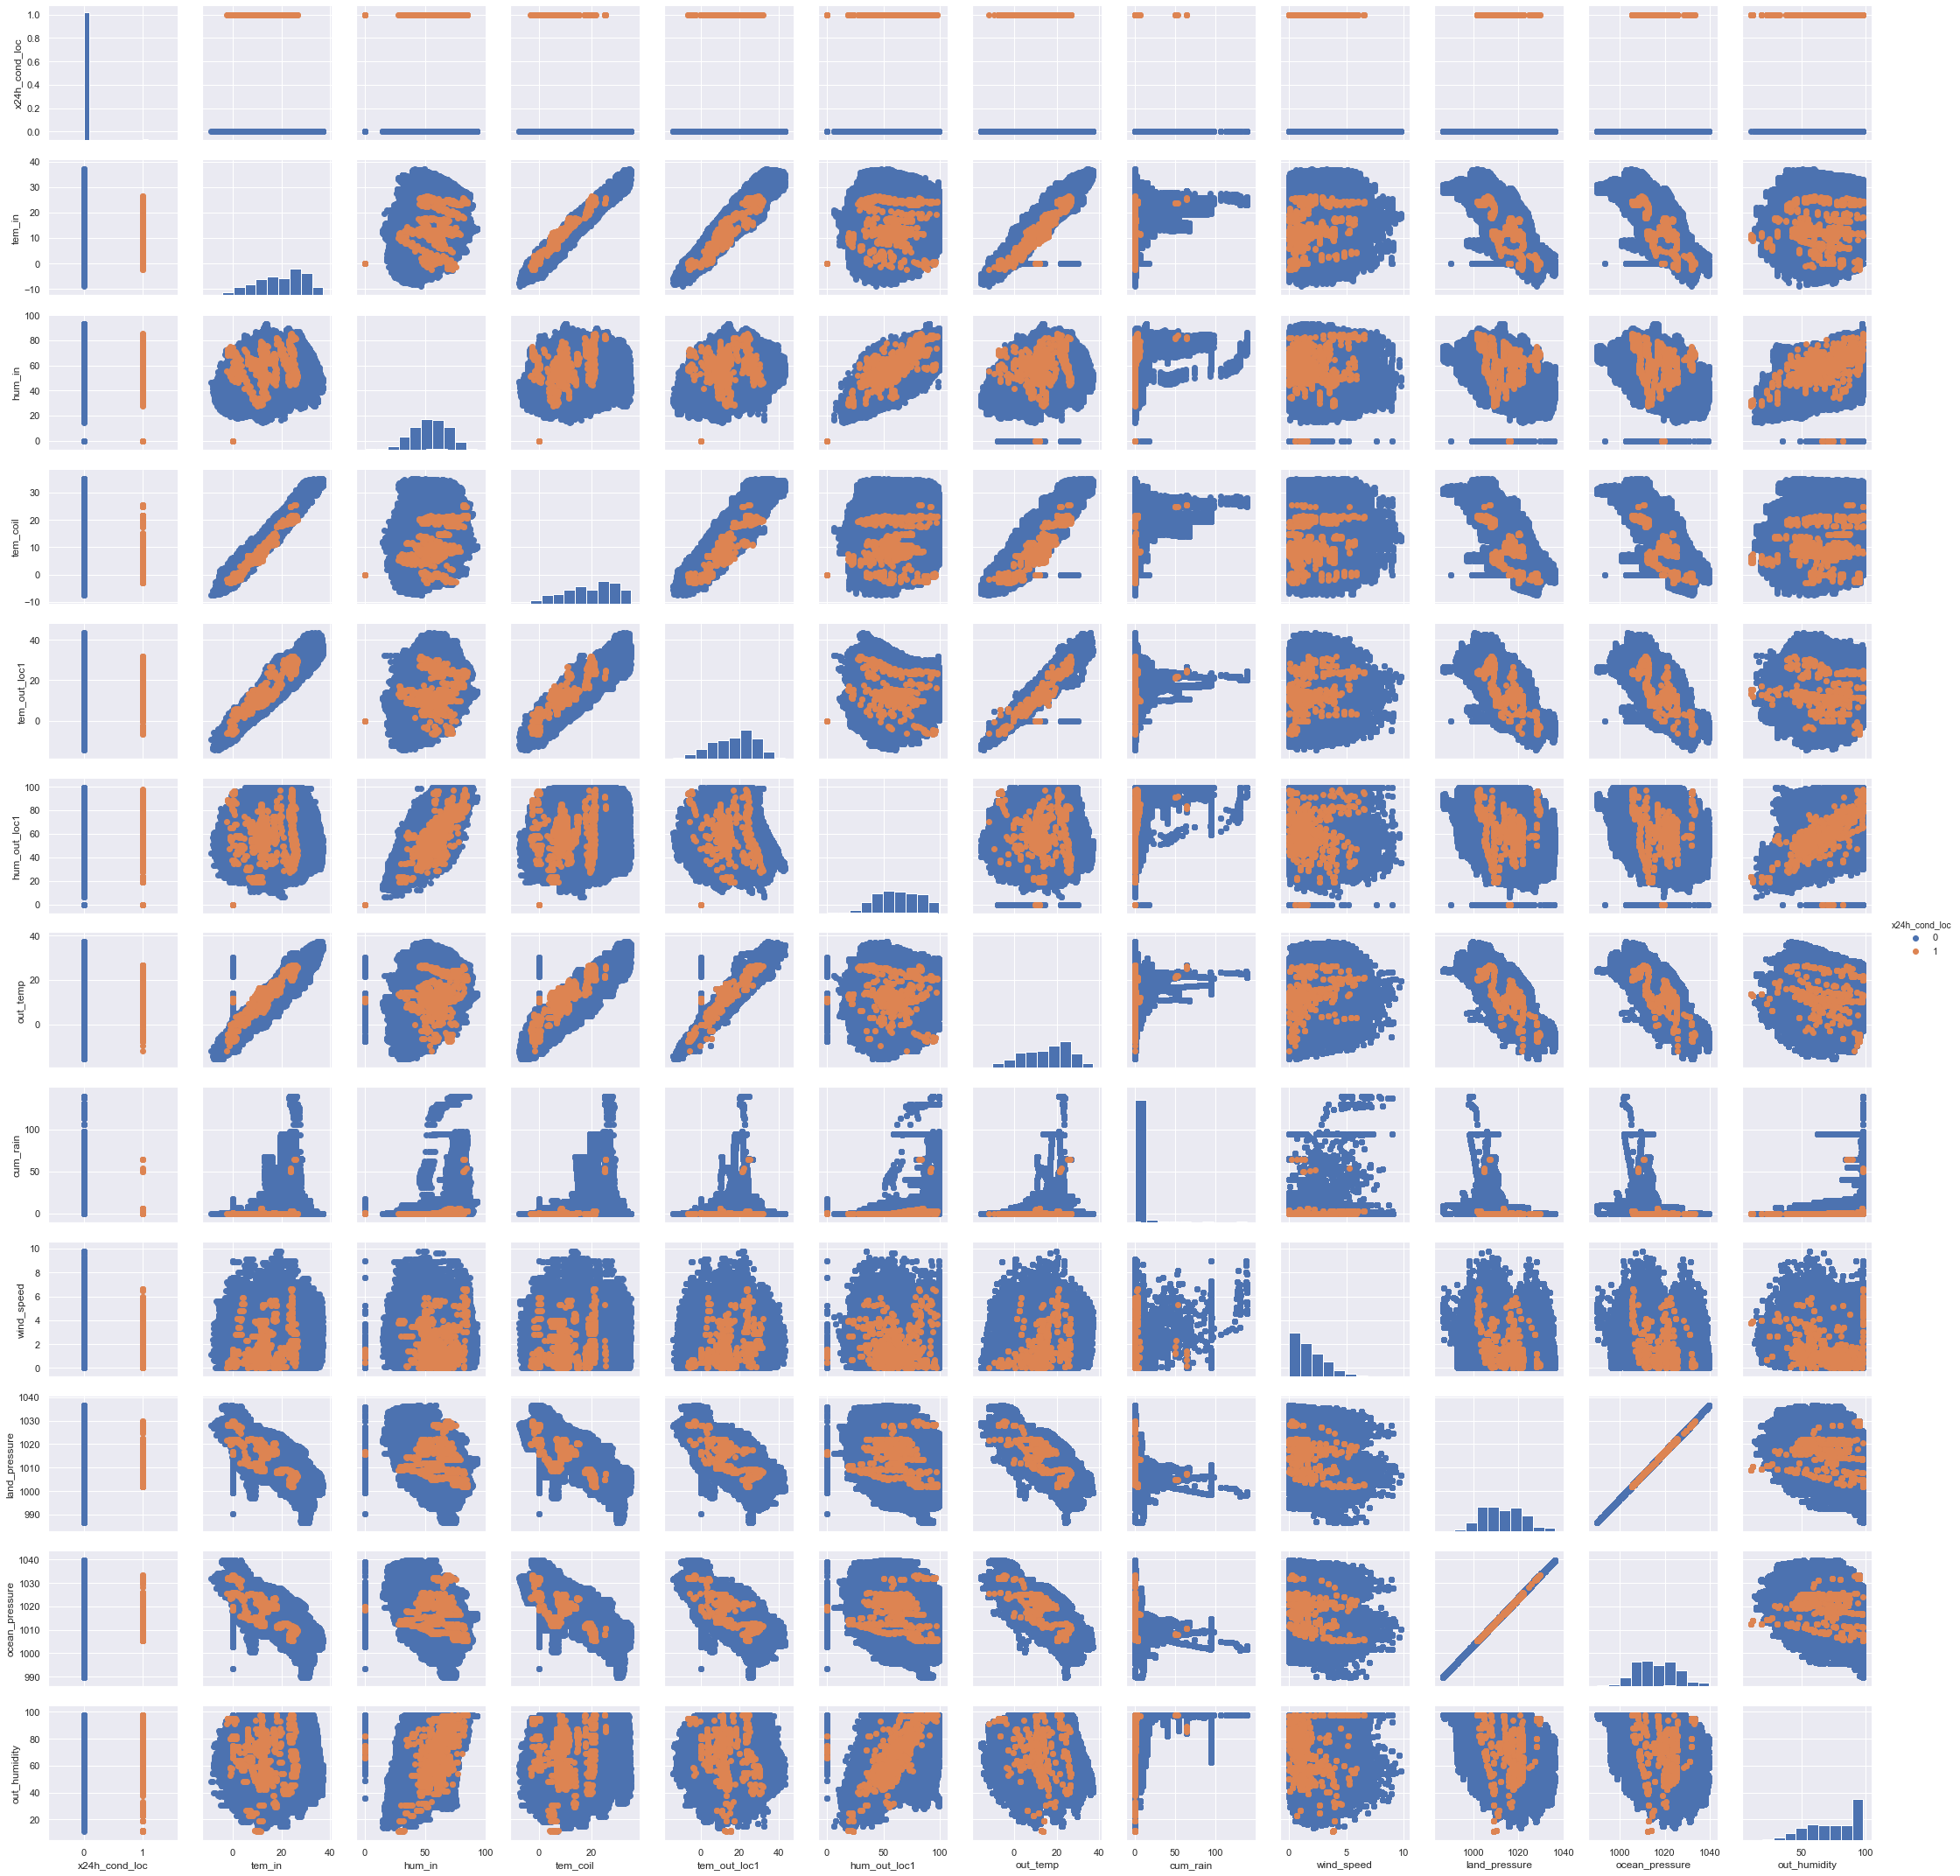

In [426]:
g = sns.PairGrid(train1_2018.iloc[:,[9,3,4,5,6,7,12,13,14,15,16,17]], hue="x24h_cond_loc")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

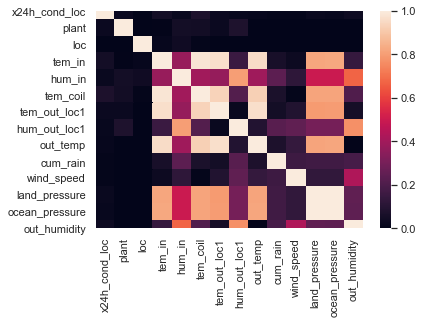

In [459]:
# Absolute correlation of each variable on 24hour later
sns.heatmap(train1_2018.iloc[:,[9,1,2,3,4,5,6,7,12,13,14,15,16,17]].corr().abs())

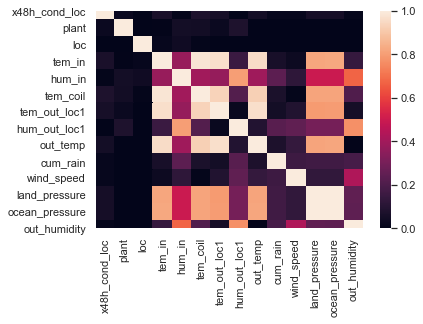

In [469]:
# Absolute correlation of each variable on 48hour later
sns.heatmap(train1_2018.iloc[:,[11,1,2,3,4,5,6,7,12,13,14,15,16,17]].corr().abs())

- For condition, only humidity related variables has meaningful correlation.
- All humidity variables are related to each other.
- Air pressure has more correlation on temperature than humidity.
- Wind speed and cumulative rain has small correlation with other variables.

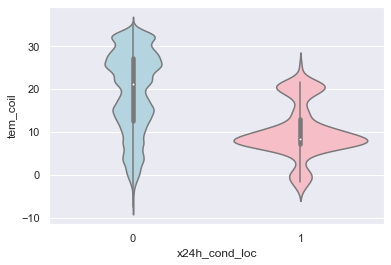

In [460]:
sns.violinplot("x24h_cond_loc", "tem_coil", data=train1_2018,
               palette=["lightblue", "lightpink"])

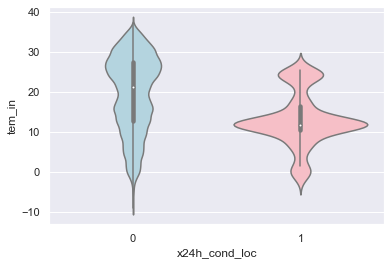

In [461]:
sns.violinplot("x24h_cond_loc", "tem_in", data=train1_2018,
               palette=["lightblue", "lightpink"])

## Feature Selection by Logistic Regression

In [462]:
mix_train = mix_train.fillna(0)

In [463]:
import statsmodels.api as sm

In [464]:
# Model for condition by each plant and location
# statsmodels requires us to add a constant column representing the intercept
mix_train['intercept']=1.0
# identify the independent variables 
ind_cols=['plant','loc','tem_in', 'hum_in','tem_coil',
          'tem_out_loc1', 'hum_out_loc1', 'out_temp', 'cum_rain', 
          'land_pressure', 'ocean_pressure', 'out_humidity']
logit = sm.Logit(mix_train['x24h_cond_loc'], mix_train[ind_cols])
result=logit.fit()

Optimization terminated successfully.
         Current function value: 0.027432
         Iterations 11


In [465]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:          x24h_cond_loc   No. Observations:               350115
Model:                          Logit   Df Residuals:                   350103
Method:                           MLE   Df Model:                           11
Date:                Thu, 18 Jun 2020   Pseudo R-squ.:                  0.2138
Time:                        14:09:51   Log-Likelihood:                -9604.4
converged:                       True   LL-Null:                       -12216.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
plant             -1.4151      0.049    -28.793      0.000      -1.511      -1.319
loc               -0.4047      0.027    -14.800      0.000      -0.458      -0.351
tem_in             0.1587      0.021

In [466]:
# Model for condition by each plant and location
# statsmodels requires us to add a constant column representing the intercept
mix_train['intercept']=1.0
# identify the independent variables 
ind_cols=['plant','loc','tem_in', 'hum_in','tem_coil',
          'tem_out_loc1', 'hum_out_loc1', 'out_temp', 'cum_rain', 
          'land_pressure', 'ocean_pressure', 'out_humidity']
logit = sm.Logit(mix_train['x48h_cond_loc'], mix_train[ind_cols])
result=logit.fit()

Optimization terminated successfully.
         Current function value: 0.031596
         Iterations 15


In [467]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:          x48h_cond_loc   No. Observations:               350115
Model:                          Logit   Df Residuals:                   350103
Method:                           MLE   Df Model:                           11
Date:                Thu, 18 Jun 2020   Pseudo R-squ.:                 0.09444
Time:                        14:09:57   Log-Likelihood:                -11062.
converged:                       True   LL-Null:                       -12216.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
plant             -1.1793      0.048    -24.500      0.000      -1.274      -1.085
loc               -0.2340      0.027     -8.628      0.000      -0.287      -0.181
tem_in         -5.266e-05      0.020

## Keras Modeling for 24 hour Forward Prediction

In [488]:
mix_train.head()

,mea_ddhr,plant,loc,tem_in,hum_in,tem_coil,tem_out_loc1,hum_out_loc1,x24h_tma,x24h_cond_loc,x48h_tma,x48h_cond_loc,out_temp,cum_rain,wind_speed,land_pressure,ocean_pressure,out_humidity
0,2016-04-01 00:00:00,1,1,16.0,24.0,11.0,9.0,42.0,2016-04-02 00:00:00,0,2016-04-03 00:00:00,0,8.8,0.0,1.5,1012.1,1015.6,41.0
1,2016-04-01 03:00:00,1,1,14.0,28.0,10.0,7.0,59.0,2016-04-02 03:00:00,0,2016-04-03 03:00:00,0,7.5,0.0,0.4,1011.4,1014.9,40.0
2,2016-04-01 06:00:00,1,1,13.0,33.0,10.0,6.0,56.0,2016-04-02 06:00:00,0,2016-04-03 06:00:00,0,3.7,0.0,0.4,1011.9,1015.5,66.0
3,2016-04-01 09:00:00,1,1,13.0,33.0,10.0,18.0,30.0,2016-04-02 09:00:00,0,2016-04-03 09:00:00,0,12.9,0.0,0.7,1013.2,1016.7,41.0
4,2016-04-01 12:00:00,1,1,16.0,28.0,10.0,18.0,20.0,2016-04-02 12:00:00,0,2016-04-03 12:00:00,0,20.5,0.0,2.4,1012.4,1015.8,24.0


In [498]:
mix_test['x24h_cond_loc'] = -1
mix_test['x48h_cond_loc'] = -1

In [523]:
frames = [mix_train, mix_test]
total_data = pd.concat(frames, sort = False)

In [725]:
total_data = total_data.fillna(0) 
mix_train = mix_train.fillna(0) 
mix_test = mix_test.fillna(0) 

In [619]:
def create_mlp(dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(300, input_dim=dim, activation="relu"))
    model.add(Dense(300, activation="relu"))

    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))

    # return our model
    return model

In [620]:
def process_weather_attributes(df, train, test):
    # initialize the column names of the continuous data
    continuous = ["tem_in", "hum_in", "tem_coil","tem_out_loc1", "hum_out_loc1","out_temp",
                  "cum_rain","wind_speed","land_pressure","ocean_pressure","out_humidity"]

    # performin min-max scaling each continuous feature column to
    # the range [0, 1]
    cs = MinMaxScaler()
    trainContinuous = cs.fit_transform(train[continuous])
    testContinuous = cs.transform(test[continuous])

    # one-hot encode the zip code categorical data (by definition of
    # one-hot encoing, all output features are now in the range [0, 1])
    zipBinarizer1 = LabelBinarizer().fit(df["plant"])
    zipBinarizer2 = LabelBinarizer().fit(df["loc"])
    trainCategorical1 = zipBinarizer1.transform(train["plant"])
    trainCategorical2 = zipBinarizer2.transform(train["loc"])
    testCategorical1 = zipBinarizer1.transform(test["plant"])
    testCategorical2 = zipBinarizer2.transform(test["loc"])

    # construct our training and testing data points by concatenating
    # the categorical features with the continuous features
    trainX = np.hstack([trainCategorical1, trainCategorical2, trainContinuous])
    testX = np.hstack([testCategorical1, testCategorical2, testContinuous])

    # return the concatenated training and testing data
    return (trainX, testX)

In [621]:
trainY1 = mix_train["x24h_cond_loc"]
trainY2 = mix_train["x48h_cond_loc"]
testY1 = mix_test["x24h_cond_loc"]
testY2 = mix_test["x48h_cond_loc"]

In [622]:
(trainAttrX, testAttrX) = process_weather_attributes(total_data, mix_train, mix_test)

In [623]:
mlp = create_mlp(trainAttrX.shape[1], regress=True)

In [706]:
x = Dense(500, activation="relu")(mlp.output)
    
x = Dense(300, activation="relu")(x)
    
x = Dense(50, activation="relu")(x)
    
y = Dense(2, activation="softmax")(x)

In [707]:
model = Model(inputs=[mlp.input], outputs=y)

In [708]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [711]:
# Train model for 24 hour forward
model.fit(trainAttrX, np.array(trainY1), 
          validation_split=0.2,
          epochs=10, batch_size=1000)

Train on 280092 samples, validate on 70023 samples
Epoch 1/10
280092/280092 [==============================] - 3s 12us/sample - loss: 0.0290 - accuracy: 0.9932 - val_loss: 0.0080 - val_accuracy: 0.9991
Epoch 2/10
280092/280092 [==============================] - 3s 12us/sample - loss: 0.0288 - accuracy: 0.9932 - val_loss: 0.0082 - val_accuracy: 0.9991
Epoch 3/10
280092/280092 [==============================] - 3s 12us/sample - loss: 0.0289 - accuracy: 0.9932 - val_loss: 0.0083 - val_accuracy: 0.9991
Epoch 4/10
280092/280092 [==============================] - 3s 12us/sample - loss: 0.0289 - accuracy: 0.9932 - val_loss: 0.0112 - val_accuracy: 0.9991
Epoch 5/10
280092/280092 [==============================] - 4s 13us/sample - loss: 0.0289 - accuracy: 0.9932 - val_loss: 0.0080 - val_accuracy: 0.9991
Epoch 6/10
280092/280092 [==============================] - 4s 13us/sample - loss: 0.0290 - accuracy: 0.9932 - val_loss: 0.0090 - val_accuracy: 0.9991
Epoch 7/10
280092/280092 [=================

In [697]:
preds = model.predict(trainAttrX)

In [698]:
preds

array([[9.9953401e-01, 4.6601708e-04],
       [9.9874371e-01, 1.2563439e-03],
       [9.9938130e-01, 6.1868184e-04],
       ...,
       [9.9999905e-01, 9.6618294e-07],
       [9.9999905e-01, 9.4772031e-07],
       [9.9999988e-01, 1.2460761e-07]], dtype=float32)

In [699]:
np.unique(preds.argmax(1))

array([0])

In [701]:
scores = model.evaluate(trainAttrX, np.array(trainY1), verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   


Accuracy on training data: 0.9943475723266602% 
 Error on training data: 0.005652427673339844


## Keras Modeling for 48 hour Forward Prediction

In [686]:
# Train model for 48 hour forward
model.fit(trainAttrX, np.array(trainY2), 
          validation_split=0.2,
          epochs=100, batch_size=1000)

Train on 280092 samples, validate on 70023 samples
Epoch 1/100
280092/280092 [==============================] - 19s 67us/sample - loss: 0.0353 - accuracy: 0.9932 - val_loss: 0.0099 - val_accuracy: 0.9991
Epoch 2/100
280092/280092 [==============================] - 19s 69us/sample - loss: 0.0353 - accuracy: 0.9932 - val_loss: 0.0106 - val_accuracy: 0.9991
Epoch 3/100
280092/280092 [==============================] - 19s 69us/sample - loss: 0.0352 - accuracy: 0.9932 - val_loss: 0.0133 - val_accuracy: 0.9991
Epoch 4/100
280092/280092 [==============================] - 19s 69us/sample - loss: 0.0351 - accuracy: 0.9932 - val_loss: 0.0104 - val_accuracy: 0.9991
Epoch 5/100
280092/280092 [==============================] - 20s 71us/sample - loss: 0.0352 - accuracy: 0.9932 - val_loss: 0.0102 - val_accuracy: 0.9991
Epoch 6/100
280092/280092 [==============================] - 20s 70us/sample - loss: 0.0351 - accuracy: 0.9932 - val_loss: 0.0121 - val_accuracy: 0.9991
Epoch 7/100
280092/280092 [====

Epoch 54/100
280092/280092 [==============================] - 20s 70us/sample - loss: 0.0348 - accuracy: 0.9932 - val_loss: 0.0135 - val_accuracy: 0.9991
Epoch 55/100
280092/280092 [==============================] - 21s 76us/sample - loss: 0.0348 - accuracy: 0.9932 - val_loss: 0.0130 - val_accuracy: 0.9991
Epoch 56/100
280092/280092 [==============================] - 20s 72us/sample - loss: 0.0348 - accuracy: 0.9932 - val_loss: 0.0129 - val_accuracy: 0.9991
Epoch 57/100
280092/280092 [==============================] - 19s 69us/sample - loss: 0.0349 - accuracy: 0.9932 - val_loss: 0.0104 - val_accuracy: 0.9991
Epoch 58/100
280092/280092 [==============================] - 19s 67us/sample - loss: 0.0349 - accuracy: 0.9932 - val_loss: 0.0159 - val_accuracy: 0.9991
Epoch 59/100
280092/280092 [==============================] - 19s 69us/sample - loss: 0.0349 - accuracy: 0.9932 - val_loss: 0.0142 - val_accuracy: 0.9991
Epoch 60/100
280092/280092 [==============================] - 19s 69us/sampl

In [687]:
preds = model.predict(testAttrX)

In [688]:
np.unique(preds.argmax(1))

array([0])

## Baseline Model

In [714]:
from tensorflow import keras

In [712]:
neg, pos = np.bincount(mix_train['x24h_cond_loc'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 350115
    Positive: 1979 (0.57% of total)



In [941]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          1024, activation='relu',
          input_shape=(trainAttrX.shape[-1],)),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dense(2, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer='adam',
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [942]:
EPOCHS = 100
BATCH_SIZE = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [943]:
model = make_model()
model.summary()

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_263 (Dense)            (None, 1024)              16384     
_________________________________________________________________
dense_264 (Dense)            (None, 256)               262400    
_________________________________________________________________
dense_265 (Dense)            (None, 2)                 514       
_________________________________________________________________
dense_266 (Dense)            (None, 1)                 3         
Total params: 279,301
Trainable params: 279,301
Non-trainable params: 0
_________________________________________________________________


In [944]:
initial_bias = np.log([pos/neg])
initial_bias

array([-5.17000154])

In [945]:
pos/neg

0.005684560056989222

In [946]:
model = make_model(output_bias = initial_bias)
model.predict(trainAttrX[:10])

array([[0.00572804],
       [0.00571766],
       [0.005676  ],
       [0.00572941],
       [0.00574934],
       [0.00573751],
       [0.0057317 ],
       [0.00570172],
       [0.00565876],
       [0.00565243]], dtype=float32)

In [947]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [948]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    trainAttrX, 
    np.array(trainY1),
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_split=0.2, 
    verbose=0)

In [949]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    trainAttrX, 
    np.array(trainY1),
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_split=0.2, 
    verbose=0)

In [914]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

In [915]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

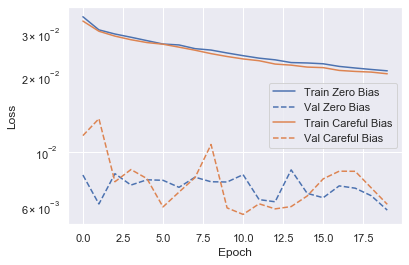

In [916]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [917]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    trainAttrX, 
    np.array(trainY1),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_split=0.2)

Train on 280092 samples, validate on 70023 samples
Epoch 1/100
280092/280092 [==============================] - 22s 77us/sample - loss: 0.0339 - tp: 1.0000 - fp: 0.0000e+00 - tn: 278179.0000 - fn: 1912.0000 - accuracy: 0.9932 - precision: 1.0000 - recall: 5.2274e-04 - auc: 0.8285 - val_loss: 0.0075 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 69957.0000 - val_fn: 66.0000 - val_accuracy: 0.9991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9111
Epoch 2/100
280092/280092 [==============================] - 20s 72us/sample - loss: 0.0304 - tp: 9.0000 - fp: 9.0000 - tn: 278170.0000 - fn: 1904.0000 - accuracy: 0.9932 - precision: 0.5000 - recall: 0.0047 - auc: 0.8898 - val_loss: 0.0093 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 69957.0000 - val_fn: 66.0000 - val_accuracy: 0.9991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9406
Epoch 3/100
280092/280092 [==============================] - 21s 74us/sample - loss: 0.0290 - tp: 50.0000 - f

Epoch 21/100
280092/280092 [==============================] - 20s 71us/sample - loss: 0.0203 - tp: 519.0000 - fp: 185.0000 - tn: 277994.0000 - fn: 1394.0000 - accuracy: 0.9944 - precision: 0.7372 - recall: 0.2713 - auc: 0.9562 - val_loss: 0.0062 - val_tp: 1.0000 - val_fp: 21.0000 - val_tn: 69936.0000 - val_fn: 65.0000 - val_accuracy: 0.9988 - val_precision: 0.0455 - val_recall: 0.0152 - val_auc: 0.9646
Epoch 22/100
280092/280092 [==============================] - 20s 70us/sample - loss: 0.0201 - tp: 541.0000 - fp: 179.0000 - tn: 278000.0000 - fn: 1372.0000 - accuracy: 0.9945 - precision: 0.7514 - recall: 0.2828 - auc: 0.9576 - val_loss: 0.0077 - val_tp: 1.0000 - val_fp: 68.0000 - val_tn: 69889.0000 - val_fn: 65.0000 - val_accuracy: 0.9981 - val_precision: 0.0145 - val_recall: 0.0152 - val_auc: 0.9639
Epoch 23/100
280092/280092 [==============================] - 20s 71us/sample - loss: 0.0199 - tp: 564.0000 - fp: 190.0000 - tn: 277989.0000 - fn: 1349.0000 - accuracy: 0.9945 - precision:

In [918]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

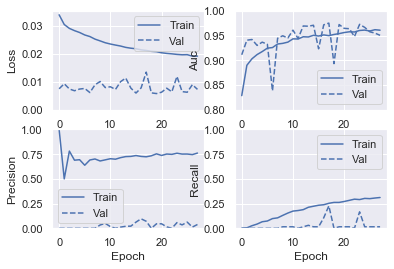

In [919]:
plot_metrics(baseline_history)

In [920]:
train_predictions_baseline = model.predict(trainAttrX, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(testAttrX, batch_size=BATCH_SIZE)

In [921]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.020885043549233463
tp :  694.0
fp :  685.0
tn :  347451.0
fn :  1285.0
accuracy :  0.99437326
precision :  0.50326324
recall :  0.35068217
auc :  0.9657207

Legitimate Transactions Detected (True Negatives):  347451
Legitimate Transactions Incorrectly Detected (False Positives):  685
Fraudulent Transactions Missed (False Negatives):  1285
Fraudulent Transactions Detected (True Positives):  694
Total Fraudulent Transactions:  1979


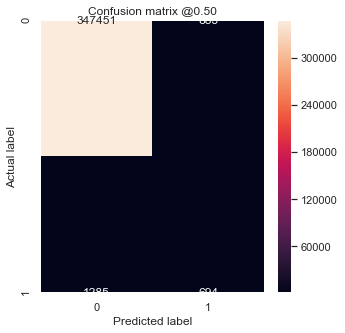

In [922]:
baseline_results = model.evaluate(trainAttrX, np.array(trainY1),
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(trainY1, train_predictions_baseline)


In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')